In [1]:
import tensorflow as tf
import numpy as np

In [2]:
train_config = {
    "disc_rate": 1.,
    "dec_rate": 0.3,
    "label_noise_rate": 0.2,
    "disc_BN": False,
    "dec_BN": True,
    "disc_dropout_during_dec_training": True
}

In [3]:
train_config_str = ",\n".join(str(train_config).split(","))

In [4]:
tf.__version__

'1.12.0'

In [5]:
disc_dropout = tf.placeholder(tf.bool, [], "disc_dropout")
disc_batchnorm = tf.placeholder(tf.bool, [], "disc_batchnorm")
dec_learning_phase = tf.placeholder(tf.bool, [], "dec_learning_phase")

sess = tf.InteractiveSession()

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
with tf.device("/cpu:0"):
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    true_data = train_dataset.concatenate(test_dataset)

In [8]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x -= 125.
    x /= 125.
    x = tf.expand_dims(x, axis=-1)
#     x = tf.image.resize_images(x, (32,32))
    return x

In [9]:
with tf.device("/cpu:0"):
    train_dataset = train_dataset.shuffle(x_train.shape[0], reshuffle_each_iteration=False)\
    .shuffle(1024).batch(256).map(preprocess)
    
    test_dataset = test_dataset.shuffle(x_test.shape[0], reshuffle_each_iteration=False)\
    .batch(256).map(preprocess)

    handle = tf.placeholder(tf.string, [])
    iterator = tf.data.Iterator.from_string_handle(handle, 
                                                   train_dataset.output_types, 
                                                   train_dataset.output_shapes)

    train_iterator = train_dataset.make_initializable_iterator()
    test_iterator = test_dataset.make_initializable_iterator()
    
    next_elt = iterator.get_next()

In [10]:
train_handle = sess.run(train_iterator.string_handle())
test_handle = sess.run(test_iterator.string_handle())

In [11]:
next_elt

<tf.Tensor 'IteratorGetNext:0' shape=(?, 28, 28, 1) dtype=float32>

In [12]:
sess.run(train_iterator.initializer)
sess.run(test_iterator.initializer)

In [13]:
import tensorflow.layers as tfl
import tensorflow.keras.layers as kerasl

In [14]:
latent_dim = 32
class Model:
    def __init__(self, learning_phase):
        self.summaries = []
        self.learning_phase = learning_phase
        
    def batchnorm(self):
        return lambda x: tfl.batch_normalization(x, training=self.learning_phase, momentum=0.5)
    
    def post_call(self, model_scope):
        if not hasattr(self, "summary_scope"):
            self.summary_scope = model_scope
    
    def dropout(self, rate=0.5):
        return lambda x: tfl.dropout(x, rate=rate, training=self.learning_phase)
    
    def add_summary(self, summ):
        self.summaries += [summ]
        
    def get_merged_summaries(self):
        with tf.variable_scope(self.summary_scope):
            return tf.summary.merge([x() for x in self.summaries])
    
class DecoderModel(Model):
    def __init__(self, learning_phase):
        super().__init__(learning_phase)
        pass
    
    def batchnorm(self):
        if train_config["dec_BN"]:
            return super().batchnorm()
        else:
            return lambda x: x
    
    def __call__(self, inp):
        with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE) as model_scope:
            x = tfl.Dense(64)(inp)
            x = self.batchnorm()(x)
            x = tf.nn.leaky_relu(x)
            
            x = tfl.Dense(256)(x)
            x = self.batchnorm()(x)
            x = tf.nn.leaky_relu(x)
            
            x = tfl.Dense(256)(x)
            x = self.batchnorm()(x)
            x = tf.nn.leaky_relu(x)
            
            x = tfl.Dense(28*28, activation=tf.nn.tanh)(x)
            x = tf.reshape(x, [-1, 28, 28, 1])
        
        self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=model_scope.name)
        self.post_call(model_scope)
        
        return x
    
    def get_variables(self):
        return self.variables
    
decoder_model = DecoderModel(dec_learning_phase)

In [15]:
# decoder_model(tf.zeros([100, latent_dim]))

In [16]:
class DiscriminatorModel(Model):
    def __init__(self, dropout_phase, batchnorm_phase):
        super().__init__(dropout_phase)
        self.batchnorm_phase = batchnorm_phase
    
    def batchnorm(self):
        if train_config["disc_BN"]:
            return lambda x: tfl.batch_normalization(x, training=self.batchnorm_phase)
        else:
            return lambda x: x
    
    def __call__(self, inp):
        with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE) as model_scope:
            x = tfl.Flatten()(inp)
            
            x = tfl.Dense(256)(x)
            x = self.batchnorm()(x)
            x = tf.nn.leaky_relu(x)
            x = self.dropout(0.25)(x)
            
            x = tfl.Dense(256)(x)
            x = self.batchnorm()(x)
            x = tf.nn.leaky_relu(x)
            x = self.dropout(0.25)(x)
            
            x = tfl.Dense(64)(x)
            x = self.batchnorm()(x)
            x = tf.nn.leaky_relu(x)
            x = self.dropout(0.25)(x)
            
            x = tfl.Dense(1, activation=None)(x)
            
        self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=model_scope.name)
        self.post_call(model_scope)
        
        return x
    
    def get_variables(self):
        return self.variables
    
discriminator_model = DiscriminatorModel(disc_dropout, disc_batchnorm)

In [17]:
def build_gan_losses():
    num_true = tf.shape(next_elt)[0]

    decoder_output = decoder_model(tf.random_normal([num_true,latent_dim]))
    num_false = tf.shape(decoder_output)[0]
    
    def build_disc_gain():
        disc_input = tf.concat([next_elt, decoder_output], axis=0)
        disc_logits = discriminator_model(disc_input)
        
        def label_noise(ln):
            return tf.random_uniform([ln, 1], maxval=train_config["label_noise_rate"])

        labels = tf.concat([tf.ones([num_true,1]), 
                            tf.zeros([num_false,1])], axis=0)
        
        labels_noisy = labels + tf.concat([-label_noise(num_true), 
                                           label_noise(num_false)], axis=0)

        disc_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_noisy, logits=disc_logits)
        disc_gain = -tf.reduce_mean(disc_loss)
        
        def accuracy(labels, preds):
            tmp = tf.cast(tf.equal(labels, tf.cast(preds, tf.float32)), tf.float32)
            print(tmp)
            return tf.reduce_mean(tmp)
        
        accuracy = accuracy(labels, tf.nn.sigmoid(disc_logits)>0.5)
        discriminator_model.add_summary(lambda: tf.summary.scalar("disc_acc", accuracy))
        discriminator_model.add_summary(lambda: tf.summary.scalar("disc_loss", -disc_gain))
        return disc_gain
    
    disc_gain = build_disc_gain()
    
    disc_input = tf.concat([next_elt, decoder_output], axis=0)
    disc_output = discriminator_model(disc_input)[num_true:]
    false_samples_logp = tf.log(tf.nn.sigmoid(disc_output))    
    dec_gain = tf.reduce_mean(false_samples_logp)
    
    decoder_model.add_summary(lambda: tf.summary.scalar("dec_loss", -dec_gain))
    return dec_gain, disc_gain

dec_gain, disc_gain = build_gan_losses()

Tensor("Cast_1:0", shape=(?, 1), dtype=float32)


In [18]:
def build_gan_update():
    opt = tf.train.AdamOptimizer(learning_rate=0.0002)

#     def build_update(gain, variables):
#         grads = tf.gradients(gain, variables)
#         grads = map(lambda x: tf.clip_by_value(x, -5., 5.), grads)
#         grads_and_vars = [(x,y) for x,y in zip(grads, variables) if x != None]
#         return opt.apply_gradients(grads_and_vars)
    
#     decoder_upd = build_update(dec_gain, decoder_model.get_variables())
#     disc_upd = build_update(disc_gain, discriminator_model.get_variables())
    decoder_upd = opt.minimize(-dec_gain, var_list=decoder_model.get_variables())
    disc_upd = opt.minimize(-disc_gain, var_list=discriminator_model.get_variables())
    return (decoder_upd, disc_upd)

In [19]:
dec_summaries = decoder_model.get_merged_summaries()
disc_summaries = discriminator_model.get_merged_summaries()

def get_dir():
    import os
    base_dir = "/home/nikita/tmp/gan_logs/"
    for ix in range(1000):
        cand = os.path.join(base_dir, "dense_" + str(ix))
        if not os.path.exists(cand):
            return cand
        
writer = tf.summary.FileWriter(get_dir())
global_step = tf.train.get_or_create_global_step()

In [20]:
decoder_upd, disc_upd = build_gan_update()
global_step_upd = global_step.assign_add(1)

decoder_upd = [decoder_upd, global_step_upd]
disc_upd = [disc_upd, global_step_upd]

In [21]:
variable_initializer = tf.global_variables_initializer()
sess.run(variable_initializer)

In [22]:
from matplotlib import pyplot as plt
num_images = 6

noise = np.random.normal(size=[num_images,latent_dim]).astype(np.float32)
ggg = decoder_model(tf.constant(noise))

class TBImUploader:
    def __init__(self, num_rows):
        self.num_rows = num_rows
        self.num_images = num_rows**2
        noise = np.random.normal(size=[self.num_images, latent_dim]).astype(np.float32)
        
        model_output = decoder_model(tf.constant(noise))
        flattened = self.flatten(model_output)
        self.summary = tf.summary.image("img", flattened)
        
    def flatten(self, img_t):
        exp = tf.reshape(img_t, [self.num_rows,self.num_rows*28,28,1])
        exp = [exp[i] for i in range(self.num_rows)]
        exp = tf.concat(exp, axis=1)
        exp = tf.expand_dims(exp, 0)
        print(exp)
        return exp
    
    def post_summary(self):
        sm = self.summary.eval({dec_learning_phase: False})
        writer.add_summary(sm, global_step.eval())
        
im_summarizer = TBImUploader(6)
    
def show_pics():
    arr = sess.run(ggg, {dec_learning_phase: False})
    arr = np.concatenate([arr[i] for i in range(arr.shape[0])], axis=1)
    plt.imshow(arr[...,0])
    plt.show()

Tensor("ExpandDims:0", shape=(1, 168, 168, 1), dtype=float32)


In [23]:
train_config_summ = tf.summary.text("train_config", tf.constant(train_config_str))
writer.add_summary(train_config_summ.eval())

In [24]:
noise = tf.random_normal([10,latent_dim])
gened = decoder_model(noise)

In [25]:
# tt = sess.run(gened, {dec_learning_phase: False})
# from matplotlib import pyplot as plt

# for i in range(tt.shape[0]):
#     plt.imshow(tt[i][...,0])
#     plt.show()

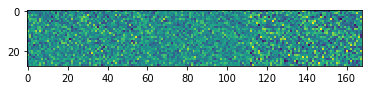

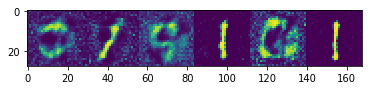

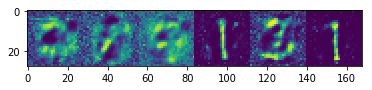

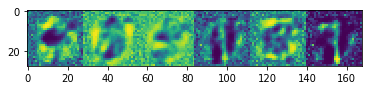

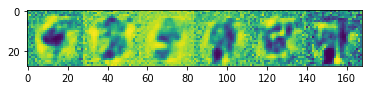

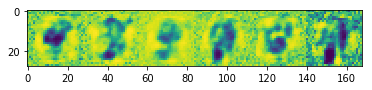

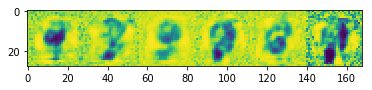

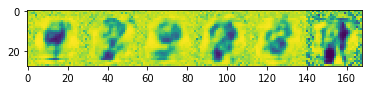

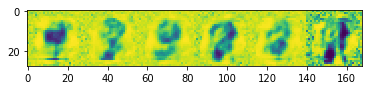

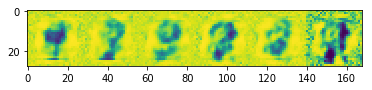

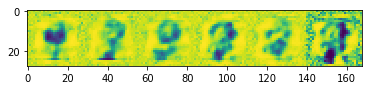

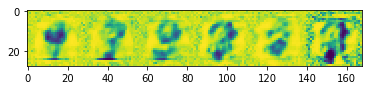

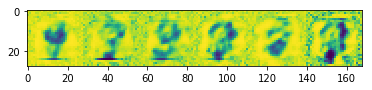

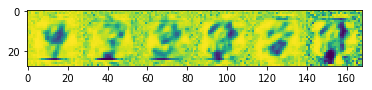

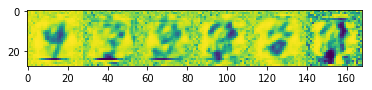

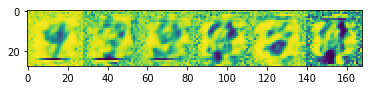

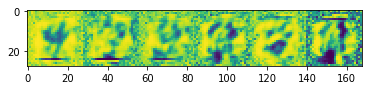

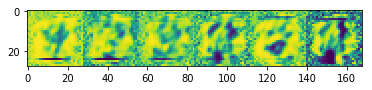

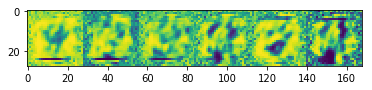

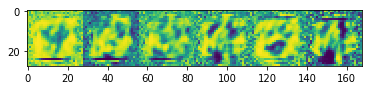

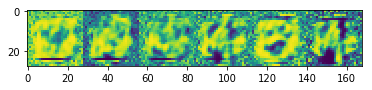

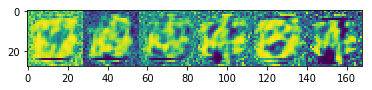

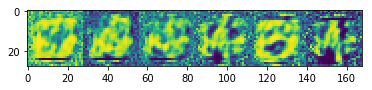

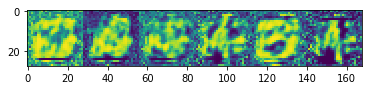

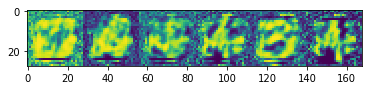

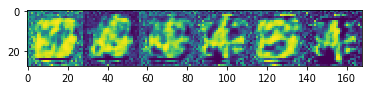

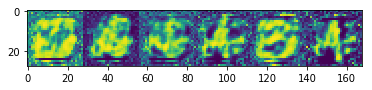

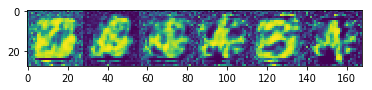

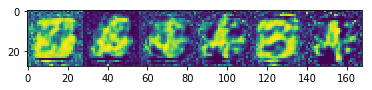

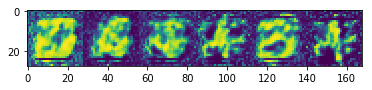

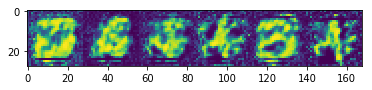

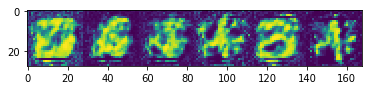

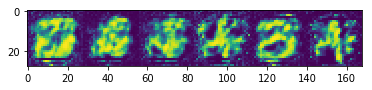

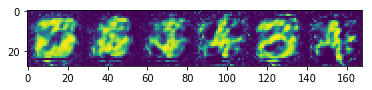

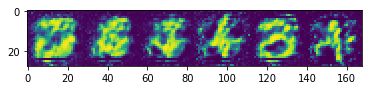

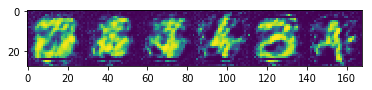

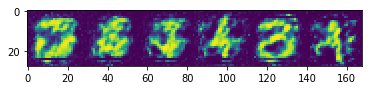

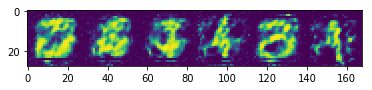

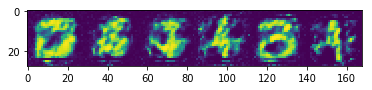

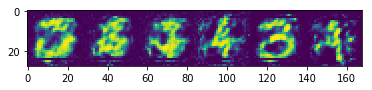

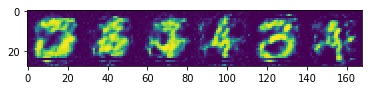

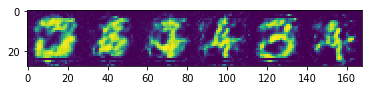

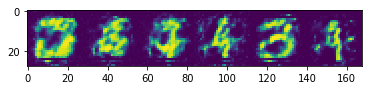

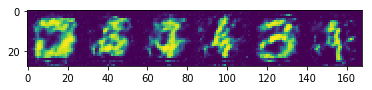

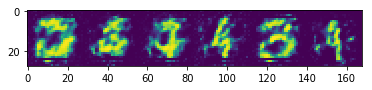

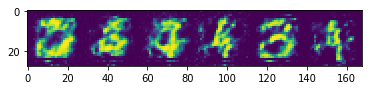

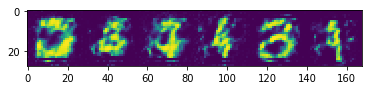

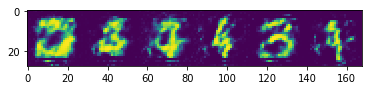

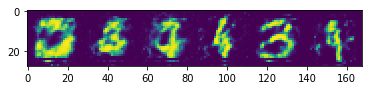

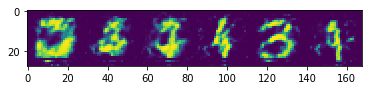

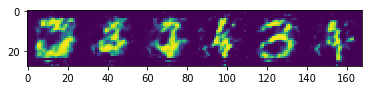

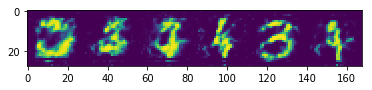

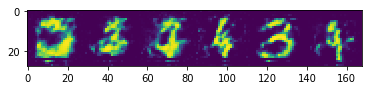

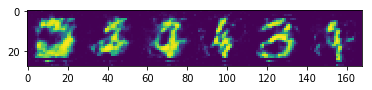

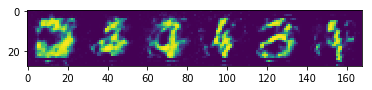

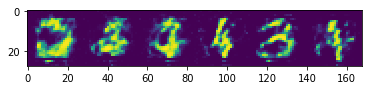

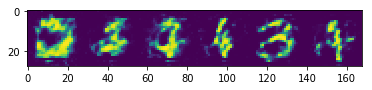

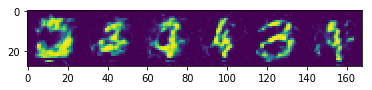

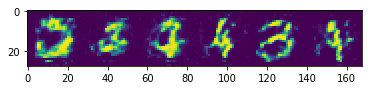

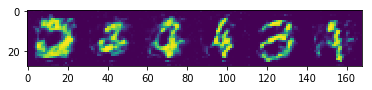

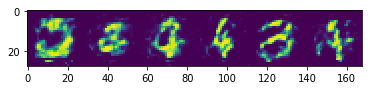

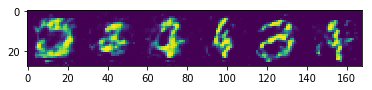

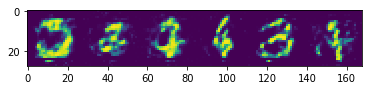

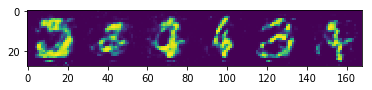

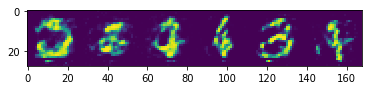

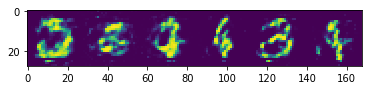

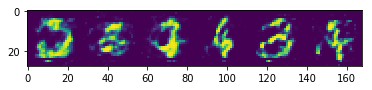

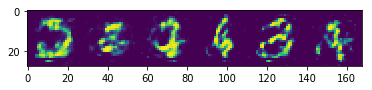

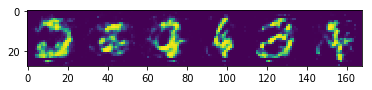

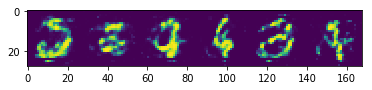

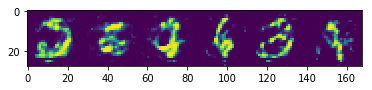

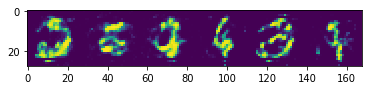

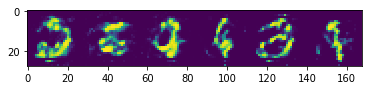

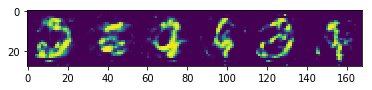

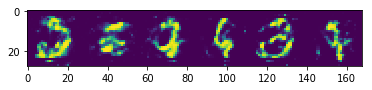

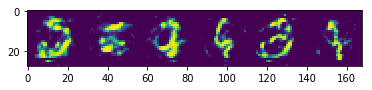

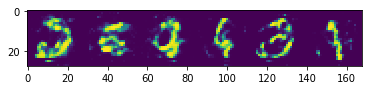

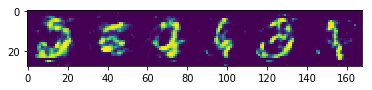

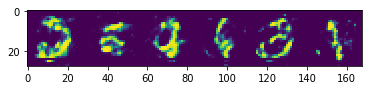

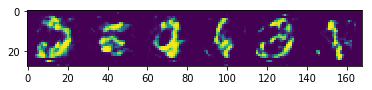

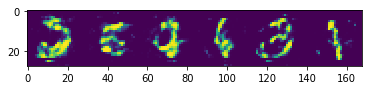

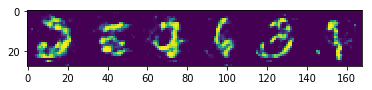

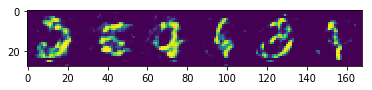

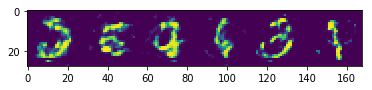

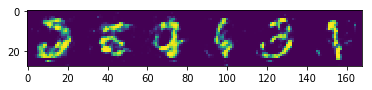

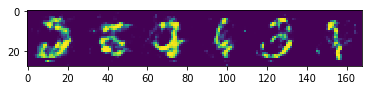

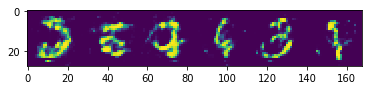

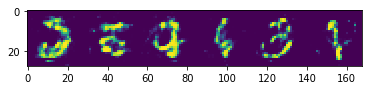

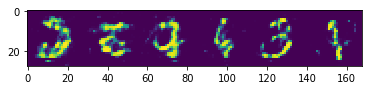

KeyboardInterrupt: 

In [26]:
import random
dec_dic = {handle: train_handle, 
           dec_learning_phase: True, 
           disc_dropout: train_config["disc_dropout_during_dec_training"],
           disc_batchnorm: True}

disc_dic = {handle: train_handle, 
            dec_learning_phase: True, 
            disc_dropout: True,
            disc_batchnorm: True}

# dec_dic = {handle: train_handle, dec_learning_phase: False, disc_learning_phase: False}
# disc_dic = {handle: train_handle, dec_learning_phase: False, disc_learning_phase: False}

for epoch in range(100000):
    if epoch % 100 == 0:
        show_pics()
    
    im_summarizer.post_summary()
    
    try:
        while True:
            if random.random() < train_config["disc_rate"]:
                _, summ = sess.run([disc_upd, disc_summaries], disc_dic)
                writer.add_summary(summ, global_step.eval())
            
            if random.random() < train_config["dec_rate"]:
                _, summ = sess.run([decoder_upd, dec_summaries], dec_dic)
                writer.add_summary(summ, global_step.eval())
    except tf.errors.OutOfRangeError:
        sess.run(train_iterator.initializer)

In [ ]:
sess.run(variable_initializer)